Remark: This notebook is for testing and integrating code changes by Christian from 181214.

# CURRENT Imports v01
from banddos.ipynb

May be changed below.

In [2]:
# Jupyter, Python imports
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

#  python 3interactive figures in a live IPython notebook session
%matplotlib nbagg

# studentproject18ws imports
import os
import logging
from studenproject18ws.hdf.reader import Reader
from studenproject18ws.hdf.recipes import Recipes


# CURRENT File selection & read v01 - hard-coded
from banddos.ipynb

In [3]:
filename = 'banddos_4x4.hdf'
# filename = 'banddos.hdf'
# filename = 'banddos_Co.hdf'

filepath = ['..', 'data', 'input', filename]
filepath = os.path.join(*filepath)

data = None
extractor = Reader(filepath=filepath)
with extractor as h5file:
    data = extractor.read(recipe=Recipes.Bands)
    #
    # Note:
    # Inside the with statement (context manager),
    # all data attributes that are type h5py Dataset are available (in-file access)
    # When the statement is left,the HDF5 file gets closed and the datasets are closed.
    #
    # Use data outside the with-statement (in-memory access: all HDF5 datasets converted to numpy ndarrays):
    data.move_datasets_to_memory()
    


In [4]:
# data (currently) has a function that returns a plt configured to .show() bandstrure plt.
# we want to reuse that code here now. So do a little magic: retrieve the function definiton

def retrieve_function_def(function):
    """Returns the function definition of a func in memory and pastes into new notebook cell.
    """
    import inspect
    get_ipython().set_next_input("".join(inspect.getsourcelines(function)[0]))

# CURRENT Plot v01 - integrate code changes by Christian 181214 Fri
adapted from banddos02.ipynb Plot v01.

**TODO: adapt to new methods from 181214.**

uses Import v01, File read v01.


<IPython.core.display.Javascript object>


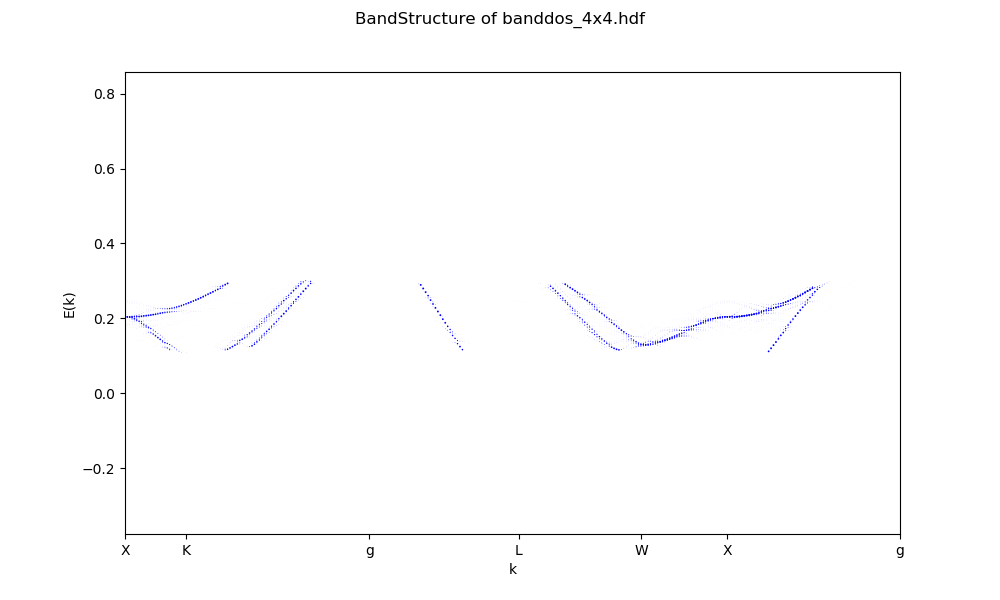

interactive(children=(IntRangeSlider(value=(1, 387), continuous_update=False, description='Bands', max=387, mi…

In [5]:
# okay, copied the relevant code from data.new_plotfunction_weights:
# defining the plt outside of the function so we can link it with widgets.

fig, ax = plt.subplots(1, figsize=(10,6))
plt.suptitle(f"BandStructure of {filename}")

# define widgets function


# bands = atom_group_keys = e.g. for banddos.hdf: dict_keys[(1,2,3,4,5)]
#                           Hm... should better convert to tuple back in reader?
def_groups = data.atom_group_keys
select_groups = widgets.SelectMultiple(options=def_groups, 
                                   value=tuple(def_groups),
                                  description='Atom Groups',
                                  disabled=False)


def_characters = ['s', 'p', 'd', 'f']
# Characters = namedtuple('Characters', ['s', 'p', 'd', 'f'])
# characters = Characters(0,1,2,3)
select_characters = widgets.SelectMultiple(options=def_characters,
                                          value=tuple(def_characters),
                                          description='Band Character',
                                          disabled=False)

# number of bands can be large, so use a rangeslider instead of selectionslider
def_bands = [band for band in range(data.eigenvalues.shape[2])]
select_bands = widgets.IntRangeSlider(value=[def_bands[0]+1,def_bands[-1]+1], 
                                      min=def_bands[0]+1, max=def_bands[-1]+1, step=1,
                                     description='Bands',
                                     disabled=False, continuous_update=False,
                                     orientation='horizontal', readout=True,
                                     readout_format='d')

# the banddos y scale changes on change in band selection.
# can disable that by storing ymin, ymax at startup (all bands selected).
#   - Apparently this does not work by setting inside the update_plot for-loop with an if-condition
#     to find ymin and ymax defined outside the function. No idea why. Perhaps try again, did sth wrong.
# Okay, for now try another solution: here outside the plot, do the for-loop separately and define
# ymin, ymax this way.
ymin, ymax = (0,0)
for n in def_bands:
    y = data.E_i(n, spin=0)
    ymin = min(ymin, np.min(y))
    ymax = max(ymax, np.max(y))

# okay, now need a checkbox to turn on/off y rescaling for the update_plot()
select_rescale_ylim = widgets.Checkbox(value=False,
                                   description='Fit y-axis',
                                   disabled=False)

@interact(bands=select_bands, characters=select_characters, groups=select_groups, fix_ylim=select_rescale_ylim)
def update_plot(bands, characters, groups, fix_ylim):
    
    ax.clear()
    
    # convert arguments to the expected format for code 181124
    bands_conved = range(bands[0]-1,bands[1])
    groups_conved = [el-1 for el in groups]
    characters_conved = [def_characters.index(el) for el in characters]
    
    # convert arguments to the expected format for code 181212
    mask_characters = [el in characters for el in def_characters]
    mask_bands = [el in bands_conved for el in def_bands]
    mask_groups = [el in [el for el in groups] for el in def_groups]
    
    
    # plot for code 181212
    spin = 0
    (k_r, E_r, W_r) = data.reshape_data(mask_bands, mask_characters, mask_groups, spin,
                                       unfolding_weight_exponent=1)
    
    #just plot points with minimal size of t
    speed_up = True
    if(speed_up == True):
        t = 1e-4
        k_r = k_r[W_r>t]
        E_r = E_r[W_r>t]
        W_r = W_r[W_r>t]
    
    ax.scatter(k_r, E_r, marker='o', c='b', s = 2 * W_r, lw=0)
    plt.xlim(0, max(data.k_distances))
    if not fix_ylim:
        plt.ylim(ymin=ymin,ymax=ymax)
    
    label = []
    for i in range(len(data.k_special_point_labels)):
        label += str(data.k_special_point_labels[i])[2]
    plt.xticks(data.k_special_points, label)
    plt.xlabel("k")
    plt.ylabel("E(k)")
    
    plt.show()
    
    